![image.png](https://i.imgur.com/a3uAqnb.png)


# **Day 2 Lab 3: Multi-Class Classification**

---
In this lab, you'll learn how to train ML Models for **multi-class classification**

# 📊 **Data**
https://www.kaggle.com/datasets/mujtabamatin/air-quality-and-pollution-assessment

> This dataset contains factors that influence pollution, and asks you to classify the **Air Quality Level**.
>
> The target classes are described as: **Good, Moderate, Poor, Hazardous**.
>
> This is a **Multiclass-Classification** problem.

The data contains the following columns:

* Temperature: Temperature in °C.
* Humidity: Relative humidity (%).
* PM2.5: Fine particulate matter concentration (µg/m³).
* PM10: Coarse particulate matter concentration (µg/m³).
* NO2: Nitrogen dioxide concentration.
* SO2: Sulfur dioxide concentration.
* CO: Carbon monoxide concentration.
* Proximity to Industrial Areas: Distance to nearest industrial zone (km).
* Population Density: People per unit area (often correlates with emissions/traffic).

> **Target**: Air Quality (e.g., Good / Moderate / Poor / Hazardous).

---

# Task 1: EDA & Data Preprocessing

## 1.1 Import Libraries

In [1]:
from IPython.display import clear_output

%pip install kagglehub catboost xgboost tqdm imbalanced-learn -q

clear_output()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
from tqdm import tqdm

%matplotlib inline

## 1.2 Read the Data

In [3]:
# Download latest version
path = kagglehub.dataset_download("mujtabamatin/air-quality-and-pollution-assessment")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'air-quality-and-pollution-assessment' dataset.
Path to dataset files: /kaggle/input/air-quality-and-pollution-assessment


In [4]:
csv_path = os.path.join(path, "updated_pollution_dataset.csv")

df = pd.read_csv(csv_path)

df.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB


## 1.3 Exploratory Data Analysis (EDA)

**Rule of thumb checklist:**

| Question | If YES | If NO |
|----------|--------|-------|
|  **1. Is the target imbalanced?** | Use F1/Precision/Recall + StratifiedKFold | Accuracy is fine + KFold |
|  **2. Missing values?** | Impute or drop | Proceed |
|  **3. Categorical columns?** | Encode them | Proceed |
|  **4. Duplicates?** | Drop them | Proceed |
|  **5. Different scales?** | Normalize | Proceed |

Target Distribution:


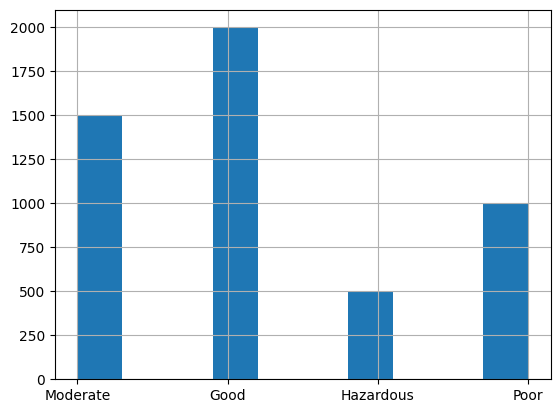

In [6]:
# 1. Is the target imbalanced?
def check_target_imbalance(df, target_column):
  print("Target Distribution:")

  df[target_column].hist()  # Yeah you can just do this :)
  plt.show()

check_target_imbalance(df, "Air Quality")

> **Rule of thumb:** If class distributions are not equal, then our data is **imbalanced**. Use StratifiedKFold and focus on F1-score. And if data distribution is balanced, StratifiedKFold will act like regular KFold, so always use StratifiedKFold :)

In [7]:
# 2. Do we have missing values?
def check_missing_values(df):

  # Get missing values using pandas
  missing_values = df.isnull().sum()

  print("Missing Values per Column:")
  print(missing_values[missing_values > 0])

  if missing_values.any():
    print("\nHandle Missing Values as needed.")
  else:
    print("\nNo Missing Values Found.")

check_missing_values(df)

Missing Values per Column:
Series([], dtype: int64)

No Missing Values Found.


In [8]:
# 3. Do we have categorical columns?
categorical_cols = df.select_dtypes(include=["object"]).columns

print("Categorical Columns:", list(categorical_cols))

Categorical Columns: ['Air Quality']


> If we have categorical columns. We need to **encode** them (convert them into numbers) for our models.

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Encode the target column
df['Air Quality'] = le.fit_transform(df['Air Quality'])

df

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,2
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,2
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,2
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,0
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,0
...,...,...,...,...,...,...,...,...,...,...
4995,40.6,74.1,116.0,126.7,45.5,25.7,2.11,2.8,765,1
4996,28.1,96.9,6.9,25.0,25.3,10.8,1.54,5.7,709,2
4997,25.9,78.2,14.2,22.1,34.8,7.8,1.63,9.6,379,2
4998,25.3,44.4,21.4,29.0,23.7,5.7,0.89,11.6,241,0


In [10]:
# 4. Check for duplicates
def check_duplicates(df):

  #TODO: get duplicated data using pandas
  duplicates = df.duplicated().sum()

  print(f"Number of Duplicate Samples: {duplicates}")
  if duplicates > 0:
    print("Dropping Duplicates...")
    df.drop_duplicates(inplace=True)
    print("Duplicates Dropped.")
  else:
    print("No Duplicate Samples Found.")

check_duplicates(df)

Number of Duplicate Samples: 0
No Duplicate Samples Found.


In [11]:
from sklearn.preprocessing import MinMaxScaler

# Pick only the numerical columns, NOT the target
numerical_cols = df.select_dtypes(include=["number"]).columns.drop("Air Quality")

scaler = MinMaxScaler()

# scale the `numerical_cols`
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

df.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,0.362832,0.250814,0.017627,0.057278,0.200000,0.301370,0.348534,0.163090,0.170351,2
1,0.329646,0.429967,0.007797,0.039241,0.406957,0.311155,0.322476,0.150215,0.550065,2
2,0.214602,0.420195,0.090508,0.107595,0.295652,0.367906,0.319218,0.115880,0.560468,2
3,0.303097,0.033659,0.020678,0.020570,0.106087,0.225049,0.162866,0.369099,0.472042,0
4,0.289823,0.376764,0.023390,0.051266,0.252174,0.230920,0.117264,0.437768,0.149545,0


In [12]:
# Prepare the data as X and y

X = df.drop("Air Quality", axis=1).astype(float)
y = df["Air Quality"].astype(float)

# Task 2: Multiclass Logistic Regression

- **Softmax Function**

Instead of Sigmoid, we use **Softmax**. It "squashes" a vector of raw scores (logits) into a probability distribution where the sum of all probabilities equals **1**:

$$\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$



- **Categorical Cross-Entropy Loss**

For multiclass problems, we use **Categorical Cross-Entropy**. This measures the difference between the predicted probability distribution and the actual "one-hot" encoded label:

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} y_{i,k} \log(\hat{y}_{i,k})$$

Where:
- $m$ = number of samples
- $K$ = number of classes
- $y_{i,k}$ = binary indicator (0 or 1) if class $k$ is the correct label for sample $i$
- $\hat{y}_{i,k}$ = predicted probability for class $k$

> **Intuition:** The loss only cares about the probability assigned to the **correct** class. If the model assigns a low probability to the true class, the penalty becomes very large!

In [13]:
# The softmax function
def softmax(z):
  z_shifted = z - np.max(z, axis=1, keepdims=True) #that take the max num in row and sub frome all feature in the same row, make more stable
  exp_z = np.exp(z_shifted)
  return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [14]:
# Categorical cross entropy loss function using NumPy
def categorical_cross_entropy(y, y_hat):
  epsilon = 1e-15
  y_hat = np.clip(y_hat, epsilon, 1 - epsilon)

  loss = -np.mean(np.sum(y * np.log(y_hat), axis=1))
  return loss

- **One-Hot Encoding**

> For multi-class, we need to convert labels [0, 1, 2, 3] into one-hot vectors:
> - Class 0: `[1, 0, 0, 0]`
> - Class 1: `[0, 1, 0, 0]`
> - Class 2: `[0, 0, 1, 0]`
> - Class 3: `[0, 0, 0, 1]`

In [15]:
def one_hot_encode(y, num_classes):
    y = np.array(y)
    m = len(y)
    # 1. Create a grid of all zeros (num_samples, num_classes)
    one_hot = np.zeros((m, num_classes))

    # 2. Go through each sample one by one
    for i in range(m):
        # Identify which class this sample belongs to
        class_label = int(y[i])

        # In this row (i), set the specific class column to 1
        one_hot[i, class_label] = 1

    return one_hot

In [16]:
def gradient_descent(X, y, num_classes, lr, n_iters=1000):
  # Get the number of samples (m) and number of features (n)
  m, n = X.shape

  # Initialize weight matrix with shape (n, num_classes)
  theta = np.zeros((n, num_classes))

  # One-hot encode the labels
  y_onehot = one_hot_encode(y, num_classes)

  losses = []

  for _ in tqdm(range(n_iters), desc="Training Multiclass Logistic Regression"):
    # Calculate the logits z
    z = np.dot(X, theta)

    # Get class probabilities using softmax
    y_pred = softmax(z)

    # Compute the gradient of Categorical Cross-Entropy with Softmax
    # ∂J/∂θ = (1/m) * X^T * (y_pred - y_onehot)
    gradient = np.dot(X.T, (y_pred - y_onehot)) / m

    # Update weights
    theta -= lr * gradient

    # Track loss
    loss = categorical_cross_entropy(y_onehot, y_pred)
    losses.append(loss)

  return theta, losses

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

In [18]:
n_splits = 3 # K=3 Folds

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [19]:
sr_results = {'loss': [], 'acc': [], 'f1': []}

for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y)):

  print(f"\nFold {fold_idx + 1}/{n_splits}")

  # Get the train & test split for this fold
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # Train using gradient descent with learning rate = 0.5
  theta, losses = gradient_descent(X_train, y_train, lr=0.5, num_classes=4)

  # Calculate z & class probabilities for X_test
  z = np.dot(X_test, theta)
  y_pred_proba = softmax(z)

  # Pick the predicted classes with the highest probability
  y_pred = np.argmax(y_pred_proba, axis=1)

  # Calculate evaluation metrics
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='macro')  # for multiclass f1 score, you should set the average hyperparameter ("macro", "micro", "weighted")

  # Store results
  sr_results['loss'].append(losses)
  sr_results['acc'].append(accuracy)
  sr_results['f1'].append(f1)


Fold 1/3


Training Multiclass Logistic Regression: 100%|██████████| 1000/1000 [00:02<00:00, 362.55it/s]



Fold 2/3


Training Multiclass Logistic Regression: 100%|██████████| 1000/1000 [00:02<00:00, 448.51it/s]



Fold 3/3


Training Multiclass Logistic Regression: 100%|██████████| 1000/1000 [00:02<00:00, 408.90it/s]


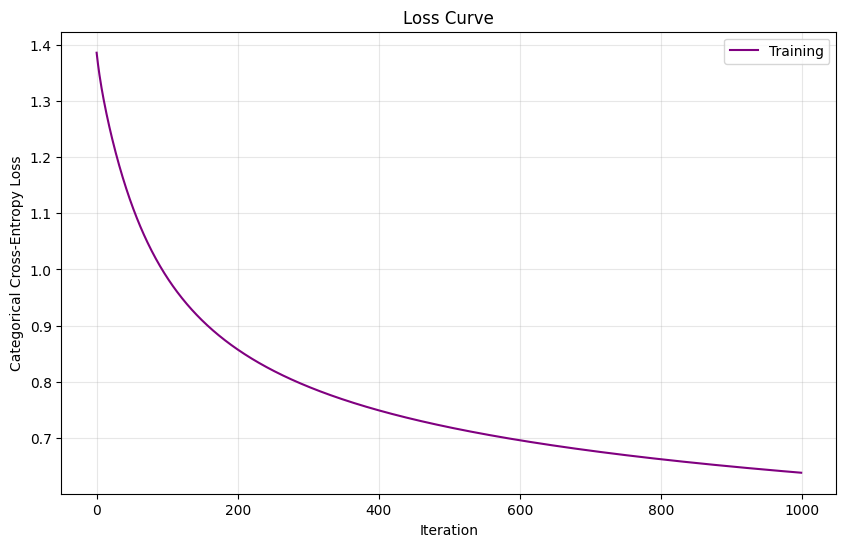

In [20]:
#TODO: Calculate the average losses across folds
avg_loss = np.mean(sr_results['loss'], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(avg_loss, label='Training', color='purple')
plt.title('Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Categorical Cross-Entropy Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [21]:
print("SOFTMAX REGRESSION Performance:")
# TODO: Print the average of each evaluation metric across folds
print(f"  Accuracy:  {np.mean(sr_results['acc']):.4f}")
print(f"  F1-Score:  {np.mean(sr_results['f1']):.4f}")

SOFTMAX REGRESSION Performance:
  Accuracy:  0.7954
  F1-Score:  0.6291


---

# Task 3: Define the ML models

In [22]:
pip install xgboost

In [23]:
# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [24]:
# TODO: Define models with hyperparameters of your choice
models = {
  "LR": LogisticRegression(
      max_iter=1000
  ),
  "KNN": KNeighborsClassifier(
      n_neighbors=3,
  ),
  "SVM": SVC(
      kernel='rbf',
      C=1.0
  ),
  "Decision Tree": DecisionTreeClassifier(
      max_depth=16
  ),
  "Random Forest": RandomForestClassifier(
      n_estimators=200,
      max_depth=10
  ),
  "XGBoost": XGBClassifier(
      verbosity=0,
      n_estimators=280,
      max_depth=10,
  ),
  "CatBoost": CatBoostClassifier(
      verbose=0,
      n_estimators=200,
      max_depth=4
  )
}

---

# Task 4: Training with Cross-Validation

In [25]:
results = {}

for model_name in models:
  results[model_name] = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

In [26]:
for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y)):
  print(f"\nFold {fold_idx + 1}/{n_splits}")

  # Get the train & test split for this fold
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # Train & Validate Models
  for model_name, model in models.items():

    print(f"Training {model_name}...")

    # Fit the model on train data
    model.fit(X_train, y_train)

    # Use the model to predict the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')  # for multiclass f1 score, you should set the average hyperparameter ("macro", "micro", "weighted")

    results[model_name]['accuracy'].append(accuracy)
    results[model_name]['f1'].append(f1)


Fold 1/3
Training LR...
Training KNN...
Training SVM...
Training Decision Tree...
Training Random Forest...
Training XGBoost...
Training CatBoost...

Fold 2/3
Training LR...
Training KNN...
Training SVM...
Training Decision Tree...
Training Random Forest...
Training XGBoost...
Training CatBoost...

Fold 3/3
Training LR...
Training KNN...
Training SVM...
Training Decision Tree...
Training Random Forest...
Training XGBoost...
Training CatBoost...


**Print the results**

In [27]:
for model_name in results:
  print(f"\n{model_name}:")
  # Print the average of each evaluation metric across folds
  print(f"  Accuracy:  {np.mean(results[model_name]['accuracy']):.4f}")
  print(f"  F1-Score:  {np.mean(results[model_name]['f1']):.4f}")


LR:
  Accuracy:  0.9268
  F1-Score:  0.8970

KNN:
  Accuracy:  0.9226
  F1-Score:  0.8851

SVM:
  Accuracy:  0.9456
  F1-Score:  0.9206

Decision Tree:
  Accuracy:  0.9164
  F1-Score:  0.8807

Random Forest:
  Accuracy:  0.9522
  F1-Score:  0.9297

XGBoost:
  Accuracy:  0.9496
  F1-Score:  0.9260

CatBoost:
  Accuracy:  0.9520
  F1-Score:  0.9287


# **Contribution: Sattam Altwaim** :)



![image.jpeg](https://i.imgflip.com/agk7s5.jpg)
